C:\Users\demko_r\AppData\Local\Temp\ipykernel_22348\3244332272.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  unet = torch.load(path_model).cpu()


tensor([[1.]])
Prediction class 1 - real class 0


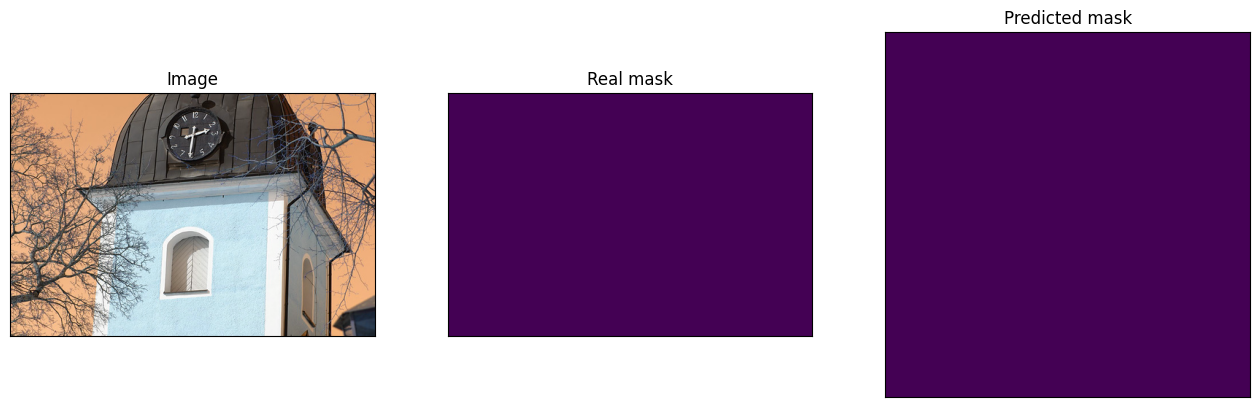

In [18]:
import os

DATA_DIR = './dataset'

def classify_image(path_image, path_model):
    
    import cv2
    import numpy as np
    import matplotlib.pyplot as plt
    import torch

    
    ENCODER = 'resnet34'
    ENCODER_WEIGHTS = 'imagenet'
    THRESHOLD = 0.5

    # preprocessing_fn = smp.encoders.get_preprocessing_fn(
    #     ENCODER, ENCODER_WEIGHTS
    # )

    image_initial = cv2.imread(path_image)
    image = cv2.cvtColor(image_initial, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (320, 320))
    image = np.transpose(image, (2, 0, 1)).astype('float32')
    image = np.expand_dims(image, 0)
    image = torch.from_numpy(image)

    mask_real = cv2.imread(
        path_image.replace('images', 'masks').replace('jpg', 'png'), 0
    )
    class_label = int((np.sum(mask_real) > 0))

    unet = torch.load(path_model).cpu()
    unet.eval()
    # switch off autograd
    with torch.no_grad():
        predicted_mask, pred_label = unet(image)
        predicted_mask = predicted_mask.squeeze()
        predicted_mask = torch.sigmoid(predicted_mask)
        predicted_mask = predicted_mask.numpy()
        # filter out the weak predictions and convert them to integers
        predicted_mask = (predicted_mask > THRESHOLD) * 255
        predicted_mask = predicted_mask.astype(np.uint8)
        predicted_mask = np.expand_dims(predicted_mask, 0)
        pred_label = int(torch.sigmoid(pred_label).round())

    # prepare a plot for visualization
    print(f'Prediction class {pred_label} - real class {class_label}')
    plt.figure(figsize=(16, 5))
    # image
    plt.subplot(1, 3, 1)
    plt.xticks([])
    plt.yticks([])
    plt.title('Image')
    plt.imshow(image_initial)
    # real mask
    plt.subplot(1, 3, 2)
    plt.xticks([])
    plt.yticks([])
    plt.title('Real mask')
    plt.imshow(mask_real)
    # predicted mask
    plt.subplot(1, 3, 3)
    plt.xticks([])
    plt.yticks([])
    plt.title('Predicted mask')
    plt.imshow(predicted_mask[0])
    plt.show()


# no human
classify_image(
    path_image=os.path.join(DATA_DIR, 'images', '000000009509.jpg'),
    path_model='unet_medpat.pth',
)


In [19]:
y_pred = [0.,0., 0., 0., 1., 1., 0., 1.] 
y_true = [1., 1., 0., 1., 1., 1., 0., 1.]
# batch metrics {'recall': 1.0, 'precision': 0.5, 'accuracy': 0.625}

In [24]:
def metrics(y_pred, y_test):
    from sklearn.metrics import accuracy_score, precision_score, recall_score

    return {
        'recall': recall_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'accuracy': accuracy_score(y_test, y_pred),
    }

metrics(y_pred, y_true)

0.5